This dataset, composed of 440 sound recordings, contains meows emitted by cats in different contexts. Specifically, 21 cats belonging to 2 breeds (Maine Coon and European Shorthair) have been repeatedly exposed to three different stimuli that act as labels for prediction:

* Waiting for food;
* Isolation in unfamiliar environment;
* Brushing (being brushed affectionately by the owner).

Naming conventions follow the pattern 
* L[label]_
* CID[Cat ID]_
* BB[Cat Breed]_
* SS[Sex]_
* OID[Owner ID]_
* R[Recording Session]
* XX[Meow counter].

The unique values are available in the 'dataset' folder description.

# 1.Import and parse file name to csv

In [1]:
import pandas as pd
import os

In [2]:
path = os.getcwd()
raw_audio_file_path = os.path.join(path,'data\\raw_wave')
label_folder = ['Brushing','Food','Environment']

In [3]:
csv_data = []

for label in label_folder:
    for file in os.listdir(os.path.join(raw_audio_file_path,label)):
        if file[0:3] == 'aug':
            continue
        file.split('_')
        csv_data.append(file.split('_'))
#         break
df = pd.DataFrame(data = csv_data, columns = ['label','Cat_id','Cat_breed','Sex','Owner_id','Recording_session_Meow_counter'])

In [4]:
df.head()

,label,Cat_id,Cat_breed,Sex,Owner_id,Recording_session_Meow_counter
0,B,ANI01,MC,FN,SIM01,101.wav
1,B,ANI01,MC,FN,SIM01,102.wav
2,B,ANI01,MC,FN,SIM01,103.wav
3,B,ANI01,MC,FN,SIM01,301.wav
4,B,ANI01,MC,FN,SIM01,302.wav


### Section conclusion: data comsist of 440 audio files(.wav) of cat calls from two species and 3 behaviors. The target of this task is to use these files to train a model that can coorectly classify the behavior based on audio input. 

# 2.Visualize categorical data to check for imbalance

In [5]:
import seaborn as sns

[Text(0.5, 1.0, 'label count')]

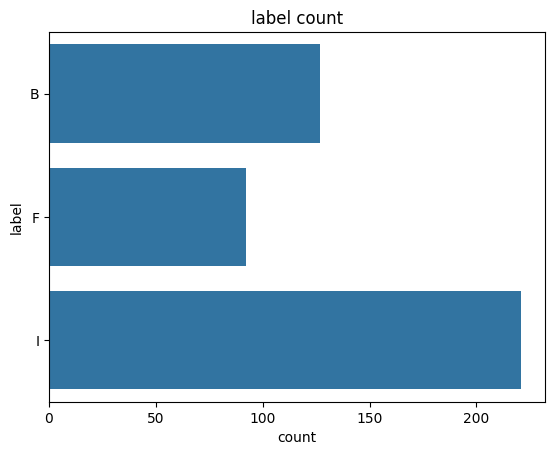

In [6]:
sns.countplot(data = df['label']).set(title='label count')

[Text(0.5, 1.0, 'label count')]

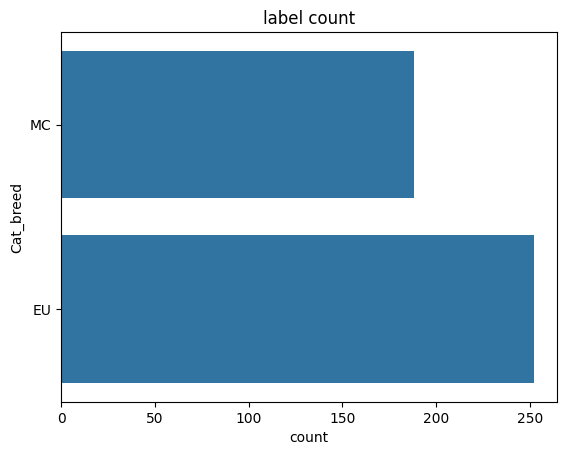

In [7]:
sns.countplot(data = df['Cat_breed']).set(title='label count')

### Section Conclusion: The target variable is imbalanced. moving forward this problem will have to be addressed.

# 3.Transfering audio file to spectrogram and convert this problem into one that may be solved by computer vision.

In [9]:
import tensorflow as tf 
import tensorflow_io as tfio
import matplotlib.pyplot as plt

In [10]:
spec_file_path = os.path.join(path,'data\\spectrogram')
spec_aug_file_path = os.path.join(path,'data\\spectrogram_aug')

In [11]:
def read_audio_file(filename):
    
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    return wav

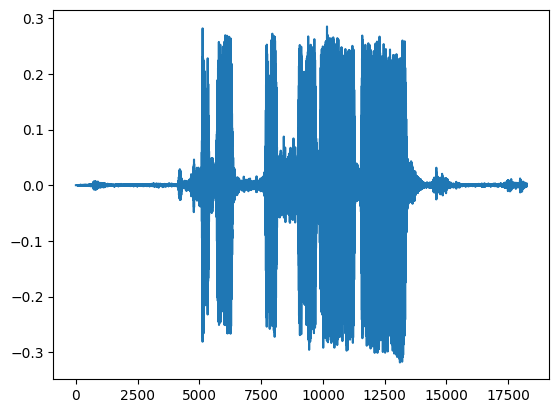

In [12]:
wave = read_audio_file(raw_audio_file_path + '\\Brushing\\B_ANI01_MC_FN_SIM01_101.wav')
plt.plot(wave)

In [13]:
lengths = []
for label in label_folder:
    for file in os.listdir(os.path.join(raw_audio_file_path, label)):
        tensor_wave = read_audio_file(os.path.join('data\\raw_wave', label, file))
        lengths.append(len(tensor_wave))
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=25194>

In [14]:
def spectrogram_builder(file_path,label):
    wav = read_audio_file(file_path)
    wav = wav[:26000]
    zero_padding = tf.zeros([26000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
# data\raw_wave\Brushing\B_ANI01_MC_FN_SIM01_101.wav
for label in label_folder:
    counter = 0
    for file in os.listdir(os.path.join(raw_audio_file_path, label)):
        
        file_path = os.path.join(raw_audio_file_path, label, file)
        save_path = os.path.join(spec_aug_file_path, label, label+'_'+str(counter))
        counter+=1
        
        spectrogram, label = spectrogram_builder(file_path,label)
        plt.figure(figsize=(30,20))
        plt.imshow(tf.transpose(spectrogram)[0])
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
        
#         plt.figure(figsize=(30,20))
#         plt.imshow(tf.transpose(spectrogram)[0])
#         plt.show()
#     break

# 4.Training the model

In [15]:
batch_size = 32
img_height = 616
img_width = 257

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    spec_aug_file_path,
    subset="training",
    validation_split=0.2,
    image_size=(img_height,img_width),
    seed=123,
    batch_size=batch_size,
    label_mode='categorical')

val_ds = tf.keras.utils.image_dataset_from_directory(
    spec_aug_file_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    label_mode='categorical')

Found 750 files belonging to 3 classes.
Using 600 files for training.
Found 750 files belonging to 3 classes.
Using 150 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['Brushing', 'Environment', 'Food']


In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 616, 257, 3)
(32, 3)


In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
import numpy as np

In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.003921569 0.9899163


In [22]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D

In [27]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size = (3,3), activation="relu", input_shape=(616,257,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

    
model.add(Flatten())
model.add(Dense(128,activation="relu"))
    
model.add(Dense(3,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 614, 255, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 307, 127, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 307, 127, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 305, 125, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 152, 62, 64)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 152, 62, 64)      

In [29]:
hist = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
19/19 [==============================] - 89s 5s/step - loss: 2473.1765 - accuracy: 0.3317 - val_loss: 1.0991 - val_accuracy: 0.3067
Epoch 2/10
19/19 [==============================] - 91s 5s/step - loss: 1.8790 - accuracy: 0.3383 - val_loss: 1.0973 - val_accuracy: 0.3933
Epoch 3/10
19/19 [==============================] - 97s 5s/step - loss: 0.9833 - accuracy: 0.4450 - val_loss: 1.0430 - val_accuracy: 0.4333
Epoch 4/10
19/19 [==============================] - 92s 5s/step - loss: 0.8021 - accuracy: 0.6517 - val_loss: 0.9812 - val_accuracy: 0.5400
Epoch 5/10
19/19 [==============================] - 84s 4s/step - loss: 0.5980 - accuracy: 0.7600 - val_loss: 0.9711 - val_accuracy: 0.5533
Epoch 6/10
19/19 [==============================] - 77s 4s/step - loss: 0.4238 - accuracy: 0.8333 - val_loss: 1.2225 - val_accuracy: 0.6000
Epoch 7/10
19/19 [==============================] - 99s 5s/step - loss: 0.2437 - accuracy: 0.9167 - val_loss: 1.1985 - val_accuracy: 0.6133
Epoch 8/10
19/19 

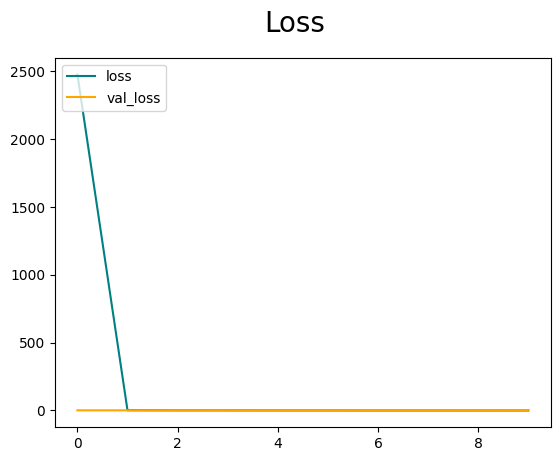

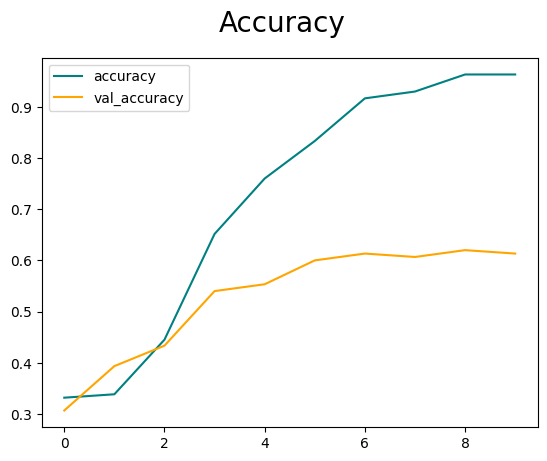

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

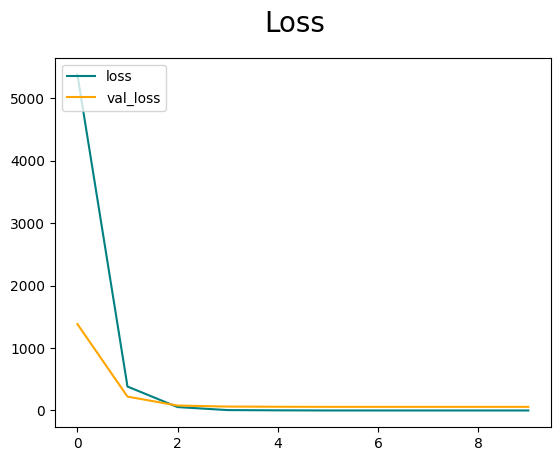

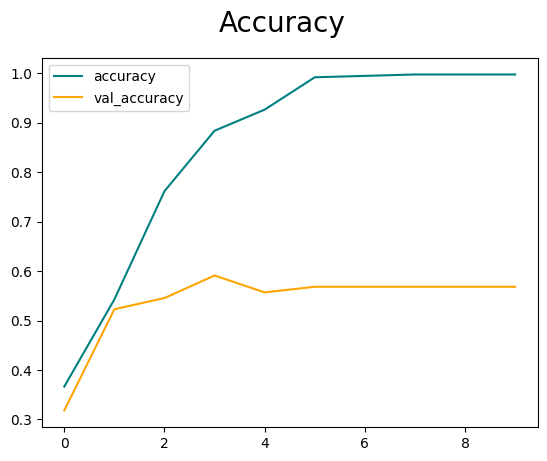

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Section conclusion: Since there is not much data to work with, the base line model was designed to use a simple two layer CNN and dropout layers to prevent overfitting, we can see that the training accuracy way higher than the valadation which signals overfitting. Other regularization method would have to be used.

# 5.Fine Tuning the model and data augmentation

use data augmentation so every class has 200 data set to train on
* Noise addition
* time scretch
* volume adjustment

In [22]:
import librosa
import numpy as np
import random
import soundfile as sf

In [28]:
augmented_audio_path = os.path.join(path,'data\\augmented_wave')

In [44]:
def add_white_noise(signal, noise_percentage_factor = 0.001):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

def time_stretch(signal):

    return librosa.effects.time_stretch(signal, rate = 0.9)

# def pitch_scale(signal, sr, n_steps):

#     return librosa.effects.pitch_shift(signal, sr = sr, n_steps = n_steps)

def random_gain(signal, min_factor=0.8, max_factor=0.8):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal


def audio_augmentation(signal,aug_fxn):
    augmented_signal = aug_fxn(signal = signal)
#     print(f'The fxn selected is  {aug_fxn}')
#     plt.plot(augmented_signal)
    return augmented_signal

In [45]:
target_num = 250
aug_type = [add_white_noise,time_stretch,random_gain]
aug_technique = random.choice(aug_type)

In [52]:
for label in label_folder:
    
    raw_file_lst = os.listdir(os.path.join(raw_audio_file_path,label))
    
    num_file = len(raw_file_lst)
    print(f'class {label} currently has {num_file} data points')
    
    create_file_num =  target_num - num_file
    print(f'{create_file_num} will be created for {label}')
    
    for num in range(create_file_num):
        
        file_to_augment = random.choice(raw_file_lst)
        print(f'{file_to_augment} is selected, and will be the {num + 1} file to be augmented for {label}')
        signal, sr = librosa.load(os.path.join(raw_audio_file_path,label,file_to_augment))
#         plt.plot(signal)
        
        aug_technique = random.choice(aug_type)
        augmented_file = audio_augmentation(signal = signal, aug_fxn = aug_technique)
        save_path = os.path.join(raw_audio_file_path,label)
        sf.write( save_path + '\\aug_'+ str(num) + file_to_augment , augmented_file, sr)

#         break
#     break
    print('=============================================================================')


class Brushing currently has 127 data points
123 will be created for Brushing
B_MAG01_EU_FN_FED01_204.wav is selected, and will be the 1 file to be augmented for Brushing
B_MAT01_EU_FN_RIT01_206.wav is selected, and will be the 2 file to be augmented for Brushing
B_BRI01_MC_FI_SIM01_202.wav is selected, and will be the 3 file to be augmented for Brushing
B_NUL01_MC_MI_SIM01_301.wav is selected, and will be the 4 file to be augmented for Brushing
B_NUL01_MC_MI_SIM01_302.wav is selected, and will be the 5 file to be augmented for Brushing
B_WHO01_MC_FI_SIM01_103.wav is selected, and will be the 6 file to be augmented for Brushing
B_BRI01_MC_FI_SIM01_303.wav is selected, and will be the 7 file to be augmented for Brushing
B_CAN01_EU_FN_GIA01_307.wav is selected, and will be the 8 file to be augmented for Brushing
B_REG01_EU_FN_GIO01_201.wav is selected, and will be the 9 file to be augmented for Brushing
B_BRI01_MC_FI_SIM01_301.wav is selected, and will be the 10 file to be augmented for 